# Mounts and installations


In [ ]:
# Mount workspace
from google.colab import drive
drive.mount('/content/drive')
!unzip -o -u "/content/drive/My Drive/ASU/Spring24/DataMining/DM-Project/product-review-sentiment-analysis.zip" -d "."

Mounted at /content/drive
Archive:  /content/drive/My Drive/ASU/Spring24/DataMining/DM-Project/product-review-sentiment-analysis.zip
   creating: ./visualization/
  inflating: ./visualization/visualization.py  
   creating: ./preprocessors/
  inflating: ./preprocessors/loaders.py  
  inflating: ./preprocessors/features.py  
 extracting: ./Makefile              
   creating: ./utils/
  inflating: ./utils/constants.py    
  inflating: ./utils/utils.py        
   creating: ./models/
   creating: ./models/LLM/
  inflating: ./models/LLM/gpt2.py    
  inflating: ./models/LLM/DistilBert.py  
  inflating: ./models/LLM/BART.py    
  inflating: ./models/LLM/llama.py   
  inflating: ./models/NN.py          
   creating: ./models/RNN/
  inflating: ./models/RNN/cnn.py     
  inflating: ./models/RNN/lstm.py    
   creating: ./evaluators/
  inflating: ./evaluators/evaluators.py  
  inflating: ./preprocessing.py      
   creating: ./Data/
   creating: ./Data/raw_data/
   creating: ./Data/raw_data/Amaz

In [ ]:
!pip install stormtrooper
!pip install datasets


  Preparing metadata (setup.py) ... done
  Created wheel for thefuzz: filename=thefuzz-0.18.0-py2.py3-none-any.whl size=18200 sha256=eb1ddb8a724d24528f315d7f7c1011d423f2c1d0b726926a7e716bf823b75355
  Stored in directory: /root/.cache/pip/wheels/8f/5b/ba/9b1a261ddd5216f10d8c6b14007d5db4b1aa16a4556d682031
Successfully built thefuzz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# Imports
# external imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# internal imports
from preprocessors import loaders
from utils import constants
from utils import utils
from visualization import visualization
from evaluators import evaluators
from models.LLM import DistilBert as bert
from models.LLM import gpt2
from models.LLM import BART as bart
from models.RNN import lstm
from models.RNN import cnn

/usr/local/lib/python3.10/dist-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# models

# LLMs
BERT = "BERT"
RoBERTa = "RoBERTa"
BART = "BART"
GPT2 = "GPT2"
DistilBERT = "DistilBERT"
DistilBERT_Amazon = "DistilBERT_Amazon"
DistilBERT_Yelp = "DistilBERT_Yelp"


# DNN
CNN = "CNN"
LSTM = "LSTM"

LLMs = {BERT, RoBERTa, BART, GPT2, DistilBERT, DistilBERT_Amazon, DistilBERT_Yelp}

DistilBERT_LLMs = {DistilBERT, DistilBERT_Amazon, DistilBERT_Yelp}


Load Datasets

In [ ]:
amazon_train_df, amazon_test_df = loaders.load_raw_data(constants.DatasetAmazon, root_path="/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis")

In [ ]:
yelp_train_df, yelp_test_df = loaders.load_raw_data(constants.DatasetYelp, root_path="/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis")

In [ ]:
max_rows = 2000
amazon_raw_dfs = [amazon_train_df[:max_rows], amazon_test_df[:max_rows]]
yelp_raw_dfs = [yelp_train_df[:max_rows], yelp_test_df[:max_rows]]

In [ ]:
amazon_tfidf = loaders.load_feature(constants.DatasetAmazon, constants.FeatureTFIDF)
yelp_tfidf = loaders.load_feature(constants.DatasetAmazon, constants.FeatureTFIDF)

In [ ]:
class EvaluatorParams:
  def __init__(self, model, model_init, train_df, test_df, output_path = None):
    self.model = model
    self.train_df = train_df
    self.test_df = test_df
    self.output_path = output_path
    self.model_init = model_init
    self.results = None
  def run(self):
    self.results = evaluators.EvaluatorResults(self.model_init(), self.model, self.train_df, self.test_df)
  def load_from_files(self):
    self.results = evaluators.evaluate_results_from_outputdir(None, self.train_df, self.test_df, self.output_path, evaluator_name=self.model)

  def get_accuracy(self, avg = False):
    accuracy = self.results.get_accuracy(False) if not avg else (self.results.get_accuracy(True) + self.results.get_accuracy(False))/2
    return round(accuracy, 2)
  def get_pred_samples_per_second(self, avg = False):
    if avg:
      train_pred_samples = int(len(self.results.train_true_labels)/self.results.get_prediction_time(True))
      test_pred_samples = int(len(self.results.test_true_labels)/self.results.get_prediction_time(False))
      return (train_pred_samples + test_pred_samples)/2
    else:
      return int(len(self.results.train_true_labels)/self.results.get_prediction_time(True))


In [ ]:
def get_accuracies_df(eval_params, include_train = True, exclude_models = {}, avg = False):
  accuracy = "Accuracy"
  df = {"Model": [], accuracy: [], "Model Type": []}
  if include_train:
    df["Dataset"] = []
    for model, eval in eval_params.items():
      if model not in exclude_models:
        df["Model"].append(model)
        df[accuracy].append(eval.results.get_accuracy(True))
        df["Dataset"].append("Train")

        df["Model"].append(model)
        df[accuracy].append(eval.results.get_accuracy(False))
        df["Dataset"].append("Test")

        df["Model Type"].append("DNN" if model not in LLMs else "LLM")
        df["Model Type"].append("DNN" if model not in LLMs else "LLM")
  else:
    for model, eval in eval_params.items():
      if model not in exclude_models:
        df["Model"].append(model)
        df[accuracy].append(eval.get_accuracy(avg = avg))
        df["Model Type"].append("DNN" if model not in LLMs else "LLM")
  return pd.DataFrame(df)

In [ ]:
def get_pred_time(eval_params, second_eval_params = None, exclude_models = {}, avg = False):
  df = {"Model": [], "Samples predicted per second": [], "Model Type": []}
  for model, eval in eval_params.items():
    if model not in exclude_models:
      df["Model"].append(model)
      df["Model Type"].append("DNN" if model not in LLMs else "LLM")
      samples_per_second = eval.get_pred_samples_per_second(avg = avg)
      if second_eval_params is not None:
        samples_per_second = (second_eval_params[model].get_pred_samples_per_second(avg = avg) + samples_per_second)//2
      df["Samples predicted per second"].append(samples_per_second)
  return pd.DataFrame(df)

# Model initialization

In [ ]:
amazon_results = {}
amazon_pre_run_results = {}

yelp_results = {}
yelp_pre_run_results = {}

In [ ]:
# BART
model = BART
model_init = lambda: bart.BARTZeroShotClassifier(device=0)

# Amazon
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/BART_ZeroShotClassifier/Amazon"
amazon_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1])
amazon_pre_run_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1], output_path)

# Yelp
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/BART_ZeroShotClassifier/Yelp"
yelp_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1])
yelp_pre_run_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1], output_path)


In [ ]:
# BERT
model = BERT
model_init = lambda: bert.ZeroShotClassifier(model = bert.BERT_MODEL, device=0)

# Amazon
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/Bert_ZeroShotClassifier/Amazon"
amazon_results[BERT] = EvaluatorParams(BERT, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1])
amazon_pre_run_results[BERT] = EvaluatorParams(BERT, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1], output_path)

# Yelp
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/Bert_ZeroShotClassifier/Yelp"
yelp_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1])
yelp_pre_run_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1], output_path)


In [ ]:
# RoBERTa
model = RoBERTa
model_init = lambda: bert.ZeroShotClassifier(model = bert.RoBERTa_MODEL, device=0)

# Amazon
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/RoBERTa_ZeroShotClassifier/Amazon"
amazon_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1])
amazon_pre_run_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1], output_path)

# Yelp
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/RoBERTa_ZeroShotClassifier/Yelp"
yelp_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1])
yelp_pre_run_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1], output_path)


In [ ]:
# DistilBERT
model = DistilBERT
model_init = lambda: bert.ZeroShotClassifier(device=0)

# Amazon
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/DistilBert_ZeroShotClassifier/Amazon"
amazon_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1])
amazon_pre_run_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1], output_path)

# Yelp
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/DistilBert_ZeroShotClassifier/Yelp"
yelp_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1])
yelp_pre_run_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1], output_path)

In [ ]:
# GPT2
model = GPT2
model_init = lambda: gpt2.ZeroShotClassifier(device=0)

# Amazon
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/GPT2Large_ZeroShotClassifier/Amazon"
amazon_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1])
amazon_pre_run_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1], output_path)

# Yelp
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/GPT2Large_ZeroShotClassifier/Yelp"
yelp_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1])
yelp_pre_run_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1], output_path)

In [ ]:
# DistilBERT - trained on Amazon dataset
model = DistilBERT_Amazon
model_init = lambda: bert.FineTunedClassifier(model_path="/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Models/DistilBert_Amazon", device=0)

# Amazon
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/DistilBert_Amazon/Amazon"
amazon_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1])
amazon_pre_run_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1], output_path)

# Yelp
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/DistilBert_Amazon/Yelp"
yelp_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1])
yelp_pre_run_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1], output_path)

In [ ]:
# DistilBERT - trained on Yelp dataset
model = DistilBERT_Yelp
model_init = lambda: bert.FineTunedClassifier(model_path="/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Models/DistilBert_Yelp", device=0)

# Amazon
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/DistilBert_Yelp/Amazon"
amazon_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1])
amazon_pre_run_results[model] = EvaluatorParams(model, model_init, amazon_raw_dfs[0], amazon_raw_dfs[1], output_path)

# Yelp
output_path = "/content/drive/My Drive/ASU/Spring24/DataMining/product-review-sentiment-analysis/Data/Output/Results/DistilBert_Yelp/Yelp"
yelp_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1])
yelp_pre_run_results[model] = EvaluatorParams(model, model_init, yelp_raw_dfs[0], yelp_raw_dfs[1], output_path)

In [ ]:
# CNN
model = CNN
model_init = lambda: cnn.Classifier(amazon_tfidf[0][constants.ColumnLabel])

# amazon
amazon_results[model] = EvaluatorParams(model, model_init, amazon_tfidf[0], amazon_tfidf[1])

# yelp
yelp_results[model] = EvaluatorParams(model, model_init, yelp_tfidf[0], yelp_tfidf[1])

In [ ]:
model = LSTM
model_init = lambda: lstm.Classifier(amazon_tfidf[0][constants.ColumnLabel], learning_rate=0.003)

# amazon
amazon_results[model] = EvaluatorParams(model, model_init, amazon_tfidf[0], amazon_tfidf[1])

# yelp
yelp_results[model] = EvaluatorParams(model, model_init, yelp_tfidf[0], yelp_tfidf[1])

# Evaluation

In [ ]:
# Amazon runs
for model in amazon_results:
  if model in LLMs:
    amazon_pre_run_results[model].load_from_files()

In [ ]:
# Yelp runs

for model in yelp_results:
  if model in LLMs:
    yelp_pre_run_results[model].load_from_files()

# Conclusion

In [ ]:
model = DistilBERT_Yelp
print(amazon_pre_run_results[model].results.display_classification_report(True))
print(yelp_pre_run_results[model].results.display_classification_report(True))

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Negative     │    0.67272  │ 0.928071 │   0.780029 │      3712 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Positive     │    0.931168 │ 0.683056 │   0.788044 │      5288 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │    0.801944 │ 0.805564 │   0.784037 │      9000 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.824573 │ 0.784111 │   0.784738 │      9000 │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛
None
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Negative     │    0.67272  │ 0.928071 │   0.780029 │   

In [ ]:
get_accuracies_df(amazon_pre_run_results)

,Model,Accuracy,Model Type,Dataset
0,BART,0.799556,LLM,Train
1,BART,0.806667,LLM,Test
2,BERT,0.516667,LLM,Train
3,BERT,0.516667,LLM,Test
4,RoBERTa,0.521444,LLM,Train
5,RoBERTa,0.521444,LLM,Test
6,DistilBERT,0.460000,LLM,Train
7,DistilBERT,0.460000,LLM,Test
8,GPT2,0.475444,LLM,Train
9,GPT2,0.474778,LLM,Test


In [ ]:
get_accuracies_df(yelp_pre_run_results)

,Model,Accuracy,Model Type,Dataset
0,BART,0.805333,LLM,Train
1,BART,0.806889,LLM,Test
2,BERT,0.516667,LLM,Train
3,BERT,0.516667,LLM,Test
4,RoBERTa,0.521444,LLM,Train
5,RoBERTa,0.521444,LLM,Test
6,DistilBERT,0.460000,LLM,Train
7,DistilBERT,0.460000,LLM,Test
8,GPT2,0.476111,LLM,Train
9,GPT2,0.480444,LLM,Test


In [ ]:
get_pred_time(amazon_results, yelp_results, exclude_models={CNN, LSTM}, avg=True)

,Model,Samples predicted per second,Model Type
0,BART,21.0,LLM
1,BERT,40.0,LLM
2,RoBERTa,41.0,LLM
3,DistilBERT,63.0,LLM
4,GPT2,12.0,LLM
5,DistilBERT_Amazon,152.0,DNN
6,DistilBERT_Yelp,149.0,DNN


In [ ]:
import matplotlib.pyplot as plt
def plot_accuracies(df, fig_name="temp.png", x = 1, title=''):
  ax = sns.barplot(x='Model', y='Accuracy',
                  hue='Dataset', data=df, palette = "Paired")
  sns.set_palette("Blues")
  sns.set_style("darkgrid")
  for i in ax.containers:
      ax.bar_label(i,)
  ax.set_title(title)
  sns.set(rc={'figure.figsize': (15, 15)})
  plt.savefig(fig_name)

In [ ]:
amazon_results[LSTM].results.test_accuracy = 0.61
amazon_results[LSTM].results.train_accuracy = 0.67
amazon_results[CNN].results.test_accuracy = 0.62
amazon_results[CNN].results.train_accuracy = 0.73

In [ ]:
amazon_pre_run_results[DistilBERT].results.display_classification_report(False)

╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Negative     │    0.428196 │ 0.922144 │   0.584828 │      3712 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Positive     │    0.712724 │ 0.13559  │   0.227836 │      5288 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │    0.57046  │ 0.528867 │   0.406332 │      9000 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │    0.595372 │ 0.46     │   0.375076 │      9000 │
╘══════════════╧═════════════╧══════════╧════════════╧═══════════╛


In [ ]:
ax = sns.barplot(x='Model', y='Samples predicted per second', data=df, palette=["#313695", "#313695", "#313695", "#313695", "#d73027", "#d73027", "#d73027"])
ax.set_title("Predication rate of LLM classifiers")
sns.set_style("darkgrid")
for i in ax.containers:
    ax.bar_label(i,)
sns.set(rc={'figure.figsize': (17, 12)})
plt.savefig("distilbert_prediction_rate.png")


ValueError: Could not interpret value `Samples predicted per second` for `y`. An entry with this name does not appear in `data`.

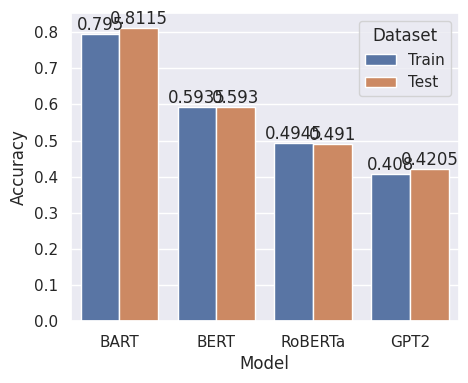

In [ ]:
plot_accuracies(get_accuracies_df(amazon_results, include_train=True, exclude_models={DistilBERT, CNN, LSTM}))

In [ ]:
df = {"Model": ["CNN", "LSTM", "LSTM", "CNN"], "Accuracy": [0.12233, 0.22, 0.12233, 0.123], "Dataset": ["Train", "Test", "Train", "Test"]}
data = pd.DataFrame(df)

<ipython-input-268-76a98ea31b21>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(


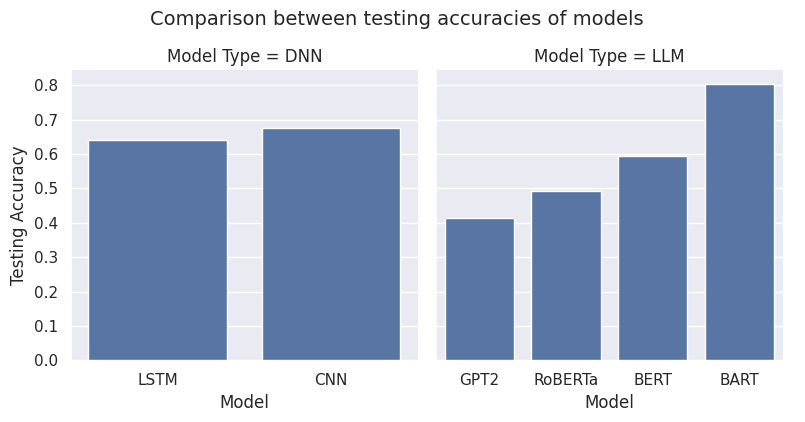

In [ ]:
ax = sns.catplot(
    data=df.iloc[::-1], x="Model", y="Testing Accuracy", col="Model Type",
    kind="bar", height=4, dodge=True, ci=None, sharex=False
)
sns.set(rc={'figure.figsize': (12, 15)})
sns.despine(bottom=True)
ax.fig.suptitle("Comparison between testing accuracies of models",
                  fontsize=14, fontdict={"weight": "bold"}, y=1.05)
plt.savefig("llm_and_dnn.png")

In [ ]:
df = get_accuracies_df(amazon_results, include_train=True, exclude_models={DistilBERT_Amazon, DistilBERT_Yelp, DistilBERT})

AttributeError: 'NoneType' object has no attribute 'get_accuracy'

In [ ]:
df = {"Model": [], "Accuracy": [], "Dataset": []}
for model in amazon_results:
  if model in LLMs:
    df["Model"].append(model)
    df["Accuracy"].append(amazon_pre_run_results[model].get_accuracy(True))
    df["Dataset"].append("Amazon")

    df["Model"].append(model)
    df["Accuracy"].append(yelp_pre_run_results[model].get_accuracy(True))
    df["Dataset"].append("Yelp")
df = pd.DataFrame(df)

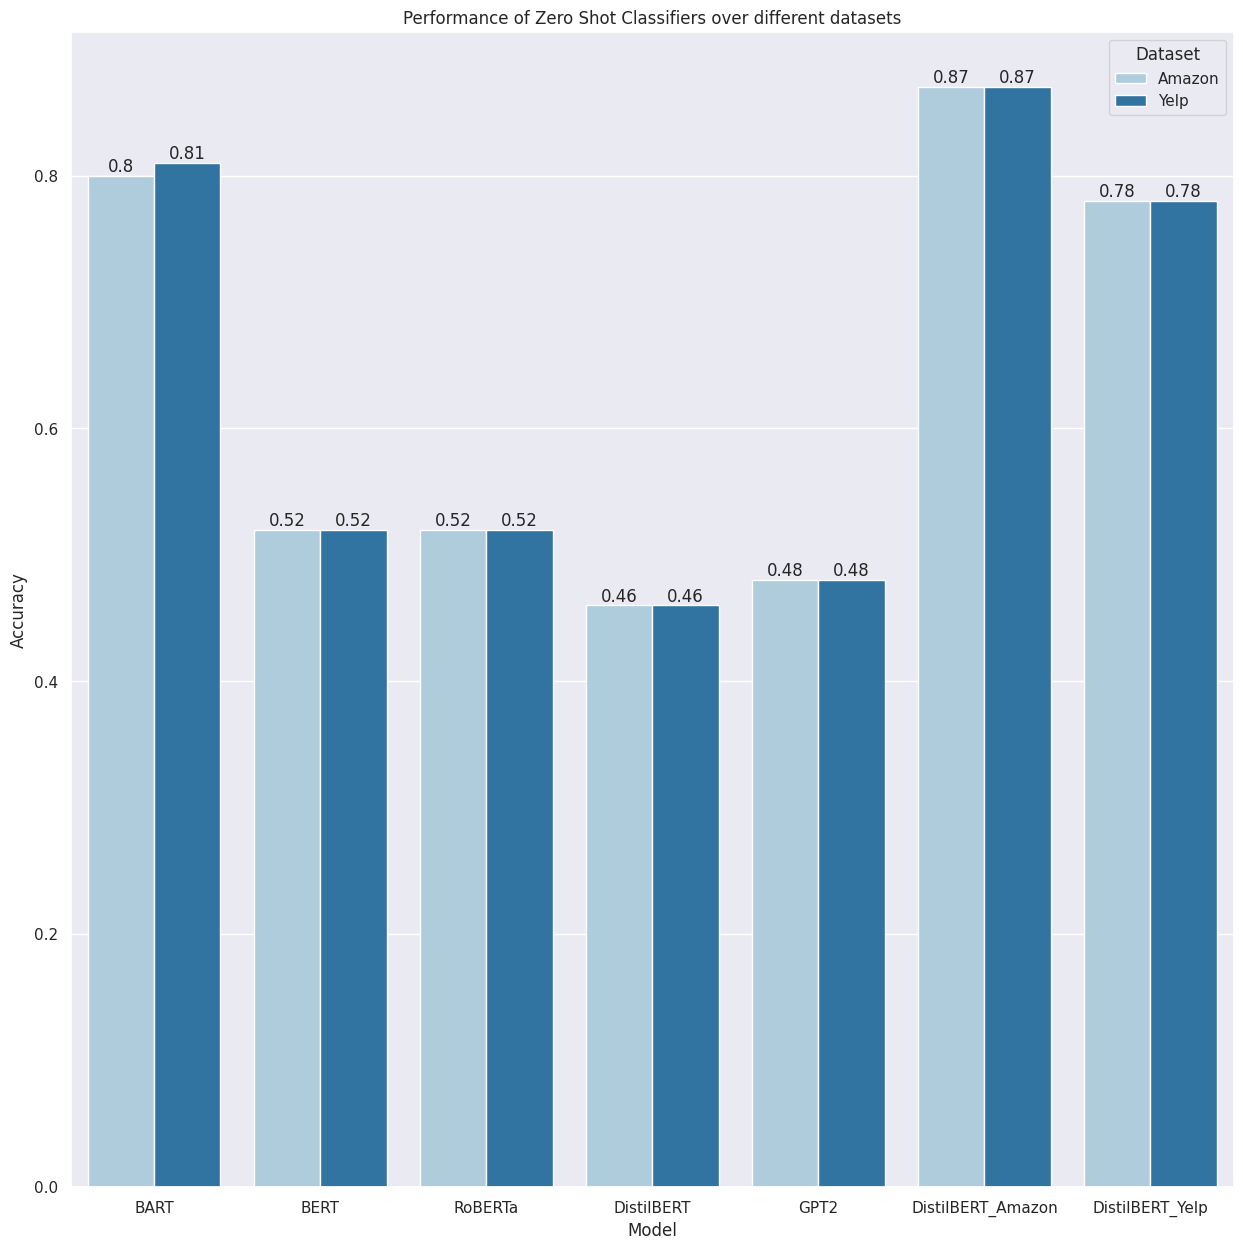

In [ ]:
plot_accuracies(df, x=2, title="Performance of Zero Shot Classifiers over different datasets")

In [ ]:
df = get_accuracies_df(amazon_results, include_train=False, avg=True, exclude_models={LSTM, CNN, DistilBERT_Amazon, DistilBERT_Yelp})

In [ ]:
df = df.sort_values(by='Accuracy', ascending=True)

In [ ]:
df

,Model,Accuracy,Model Type
4,GPT2,0.41,LLM
2,RoBERTa,0.49,LLM
3,DistilBERT,0.55,LLM
1,BERT,0.59,LLM
6,DistilBERT_Yelp,0.79,LLM
0,BART,0.80,LLM
5,DistilBERT_Amazon,0.86,LLM


In [ ]:
df.iloc[-1], df.iloc[-2] = df.iloc[-2], df.iloc[-1]

<ipython-input-417-0aa6c76f3436>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=df, palette=["#fdae61", "#fdae61", "#fdae61", "#fdae61", "#a50026"])


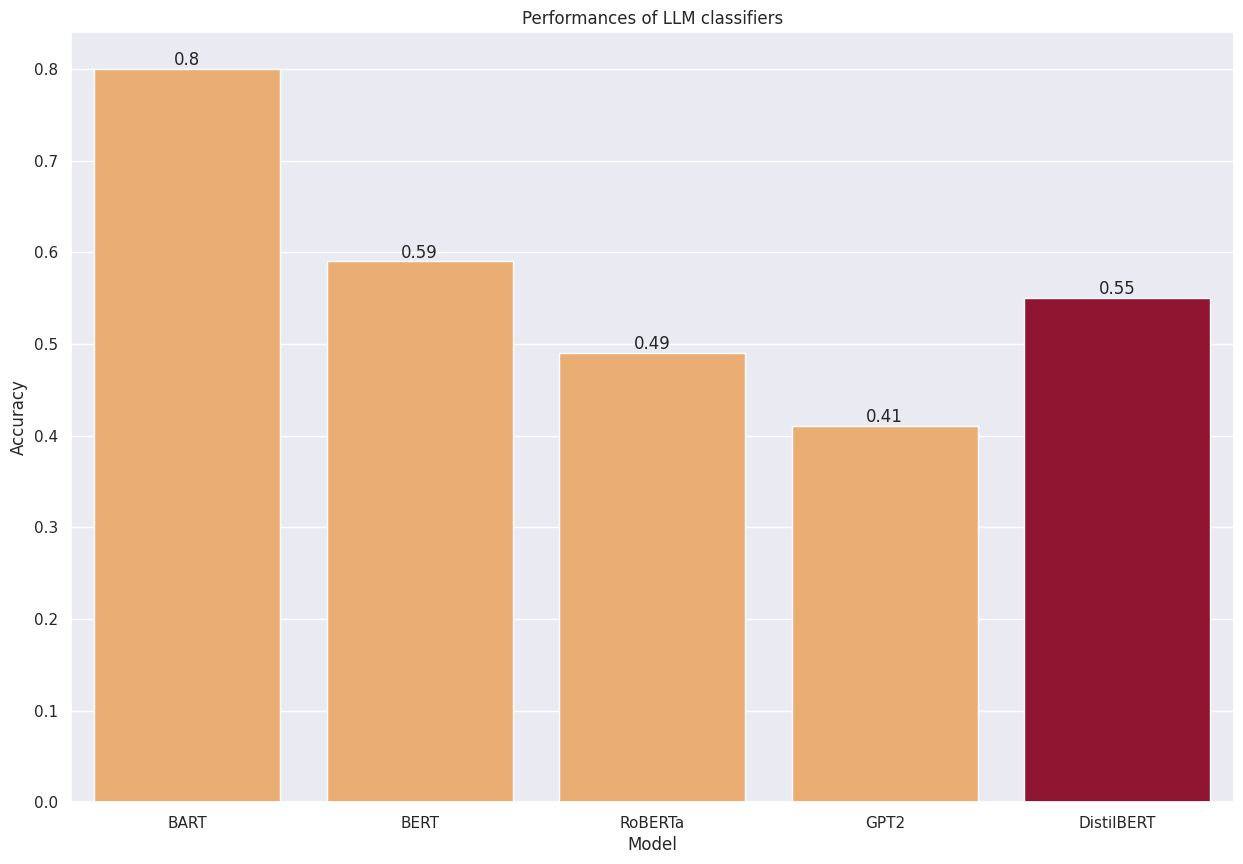

In [ ]:
ax = sns.barplot(x='Model', y='Accuracy', data=df, palette=["#fdae61", "#fdae61", "#fdae61", "#fdae61", "#a50026"])
ax.set_title("Performances of LLM classifiers")
sns.set_style("darkgrid")
for i in ax.containers:
    ax.bar_label(i,)
sns.set(rc={'figure.figsize': (15, 10)})
plt.savefig("distilbert_performance.png")

In [ ]:
df = {}

df["Dataset"] = ["Amazon", "Yelp", "Amazon", "Yelp", "Amazon", "Yelp"]
df["Model"] = ["Pre-trained DistilBERT", "Pre-trained DistilBERT", "Amazon finetuned DistilBERT", "Amazon finetuned DistilBERT", "Yelp finetuned DistilBERT", "Yelp finetuned DistilBERT"]
df["Accuracy"] = [amazon_results['DistilBERT'].get_accuracy(True), yelp_results['DistilBERT'].get_accuracy(True), amazon_results['DistilBERT_Amazon'].get_accuracy(True), yelp_results['DistilBERT_Amazon'].get_accuracy(True), amazon_results['DistilBERT_Yelp'].get_accuracy(True), yelp_results['DistilBERT_Yelp'].get_accuracy(True)]

df = pd.DataFrame(df)

In [ ]:
df

,Dataset,Model,Accuracy
0,Amazon,Pre-trained DistilBERT,0.55
1,Yelp,Pre-trained DistilBERT,0.47
2,Amazon,Amazon finetuned DistilBERT,0.86
3,Yelp,Amazon finetuned DistilBERT,0.84
4,Amazon,Yelp finetuned DistilBERT,0.79
5,Yelp,Yelp finetuned DistilBERT,0.91


<ipython-input-427-ec6bc54a3e4b>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(


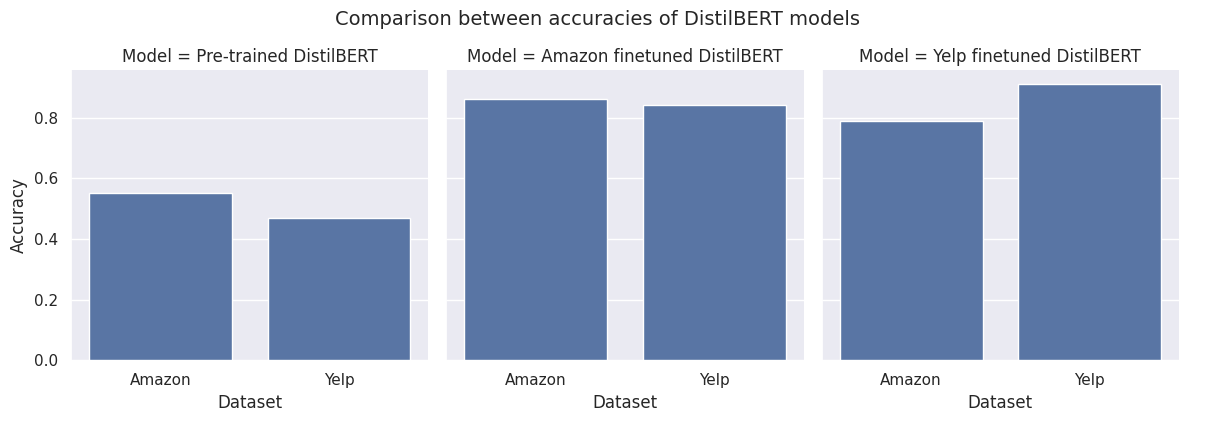

In [ ]:
ax = sns.catplot(
    data=df, x="Dataset", y="Accuracy", col="Model",
    kind="bar", height=4, dodge=True, ci=None, sharex=False
)
sns.set(rc={'figure.figsize': (15, 15)})
sns.despine(bottom=True)
ax.fig.suptitle("Comparison between accuracies of DistilBERT models",
                  fontsize=14, fontdict={"weight": "bold"}, y=1.05)
plt.savefig("all_distilbert.png")

In [ ]:
models = {
    GPT2: 812000000,
    BERT: 110000000,
    BART: 407000000,
    RoBERTa: 125000000,
    DistilBERT: 67000000
}

df = {
    "Model": ["GPT2", "BART", "RoBERTa", "BERT", "DistilBERT"],
    "Number of parameters": [812000000, 407000000, 125000000, 110000000, 67000000]
}
labels = ["812M", "407M", "125M", "110M", "67M"]
df = pd.DataFrame(df)

In [ ]:
df

,Model,Number of parameters
0,GPT2,812000000
1,BART,407000000
2,RoBERTa,125000000
3,BERT,110000000
4,DistilBERT,67000000


<ipython-input-438-0926090da62d>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Number of parameters', data=df, palette="Blues_r")


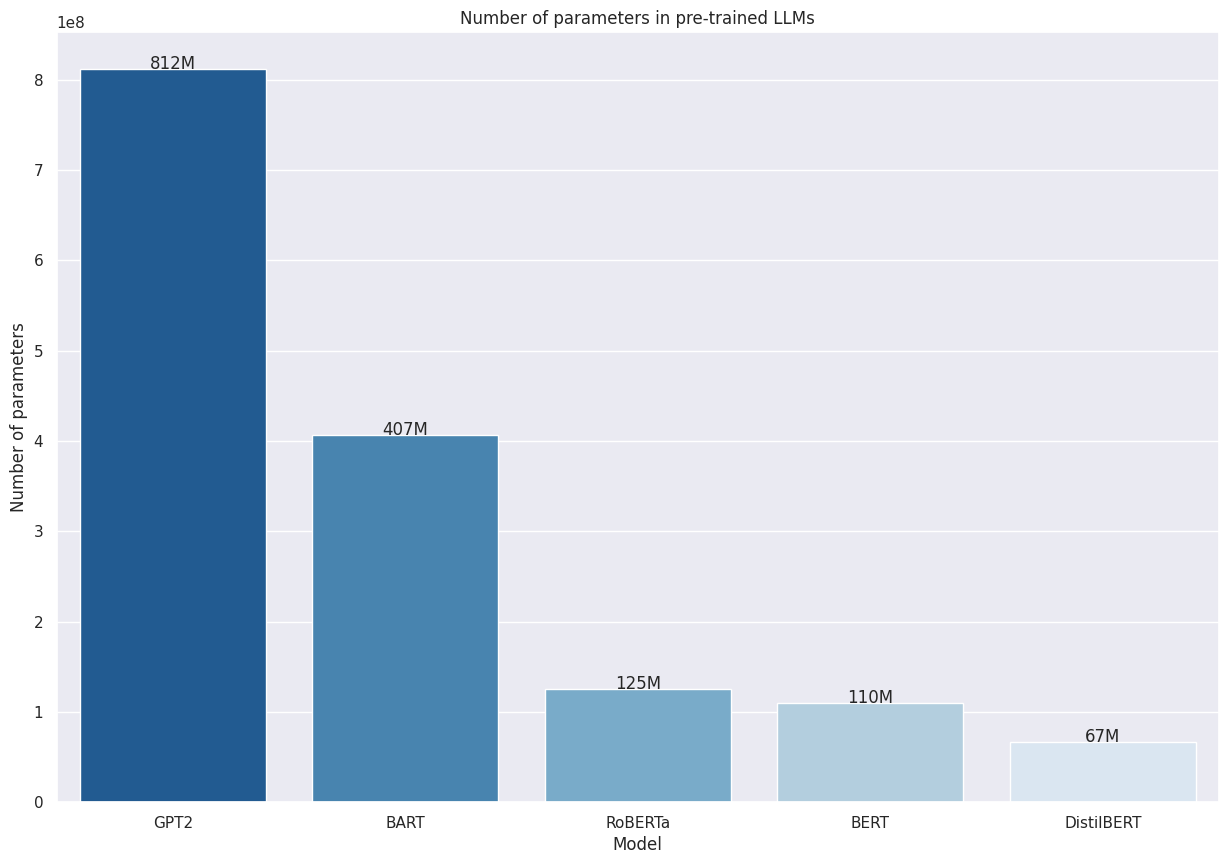

In [ ]:
ax = sns.barplot(x='Model', y='Number of parameters', data=df, palette="Blues_r")
ax.set_title("Number of parameters in pre-trained LLMs")
sns.set_style("darkgrid")
count = 0
for p in ax.patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height()
    value = labels[count]
    ax.text(_x, _y, value, ha="center")
    count += 1
sns.set(rc={'figure.figsize': (15, 10)})
plt.savefig("number_of_parameters.png")

Text(0.5, 1.0, 'Confusion Matrix for finetuned DistilBERT predictions')

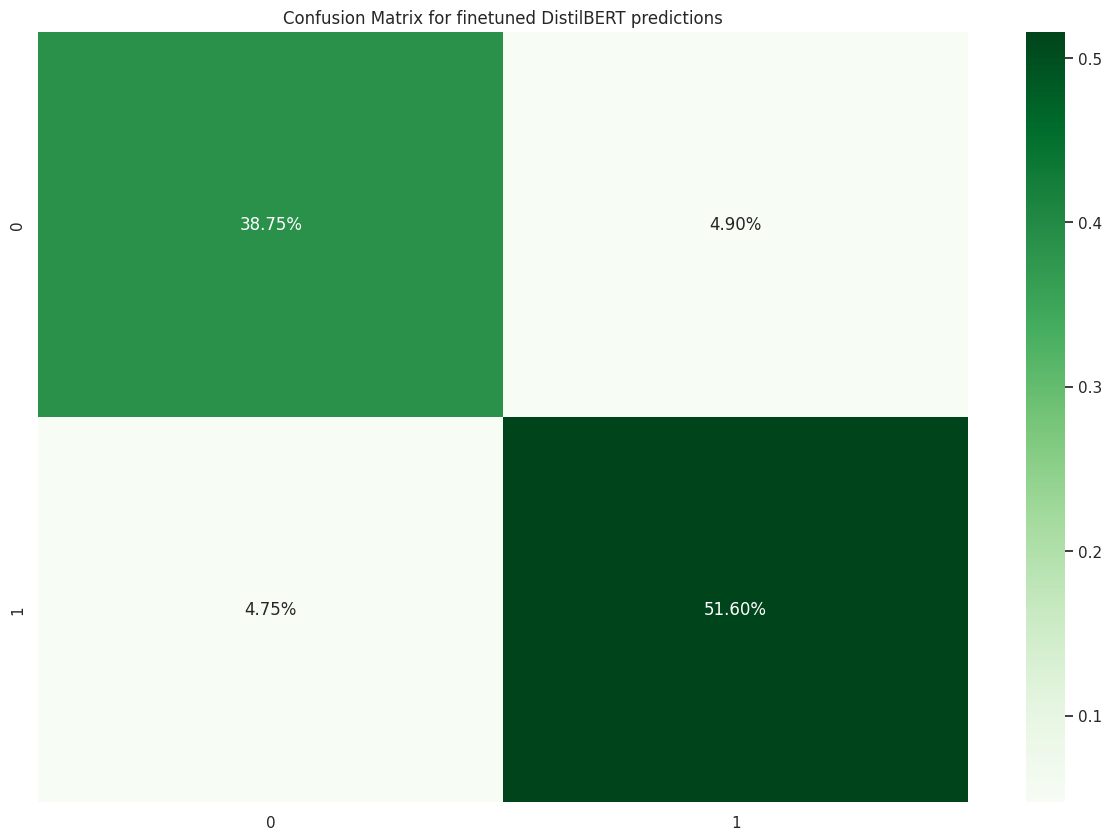

In [ ]:
cf_matrix = yelp_results['DistilBERT_Yelp'].results.train_confusion_matrix
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
            fmt='.2%', cmap='Greens')
ax.set_title  ("Confusion Matrix for finetuned DistilBERT predictions")

In [ ]:
lstm = lstm.Classifier(amazon_tfidf[0][constants.ColumnLabel])

In [ ]:
lstm.fit(amazon_tfidf[0])

Epoch 1/10
32/32 [==============================] - 4s 7ms/step - loss: 0.6735 - accuracy: 0.6170
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.6624 - accuracy: 0.6200
Epoch 3/10
32/32 [==============================] - 0s 7ms/step - loss: 0.6678 - accuracy: 0.6220
Epoch 4/10
32/32 [==============================] - 0s 7ms/step - loss: 0.6621 - accuracy: 0.6210
Epoch 5/10
32/32 [==============================] - 0s 6ms/step - loss: 0.6623 - accuracy: 0.6190
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 0.6654 - accuracy: 0.6210
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 0.6572 - accuracy: 0.6220
Epoch 8/10
32/32 [==============================] - 0s 7ms/step - loss: 0.6559 - accuracy: 0.6220
Epoch 9/10
32/32 [==============================] - 0s 7ms/step - loss: 0.6489 - accuracy: 0.6200
Epoch 10/10
32/32 [==============================] - 0s 6ms/step - loss: 0.6503 - accuracy: 0.6130


In [ ]:
lstm.model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 128)            4483584   
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4615426 (17.61 MB)
Trainable params: 4615426 (17.61 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
